In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from videpy import Vide

import stan
import nest_asyncio

plt.style.use('default')

plt.rcParams['axes.facecolor'] = 'lightgray'

In [2]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### RCode 6.1 - Pag 162

In [3]:
np.random.seed(1914)

N = 200
p = 0.1

# Não correlacionado noticiabilidade(newsworthiness) e confiabilidade(trustworthiness)
nw = np.random.normal(0, 1, N)
tw = np.random.normal(0, 1, N)

# Selecionando os 10% melhores
s = nw + tw  # Score total
q = np.quantile(s, 1-p)  # Top 10% 
selected = [ True if s_i >= q else False for s_i in s ]
print('Noticiabilidade(newsworthiness): \n', nw[selected], '\n\n')
print('Confiabilidade(trustworthiness):\n', tw[selected], '\n\n')

print('Correlação: ', np.correlate(tw[selected], nw[selected]))

Noticiabilidade(newsworthiness): 
 [ 0.82456357  1.85614543  0.85556981  1.4066898   1.6026727   1.42256068
  0.71166144  1.30222516  0.56454812  3.02039213  0.93879118  1.04202561
 -0.4640972   0.12272254  1.99579665  1.59807671  1.82853378  1.15394068
  1.48966066  1.22640255] 


Confiabilidade(trustworthiness):
 [ 1.24510334  1.29709756  2.10293057  0.66088341  1.76728533  0.64448519
  1.17598088  0.35356094  1.08805257 -0.72327249  1.31462133  1.54253157
  2.8128998   1.51862223  1.18048237  2.31948695 -0.09763283  0.87205345
  0.74979249  0.46329186] 


Correlação:  [19.93737242]


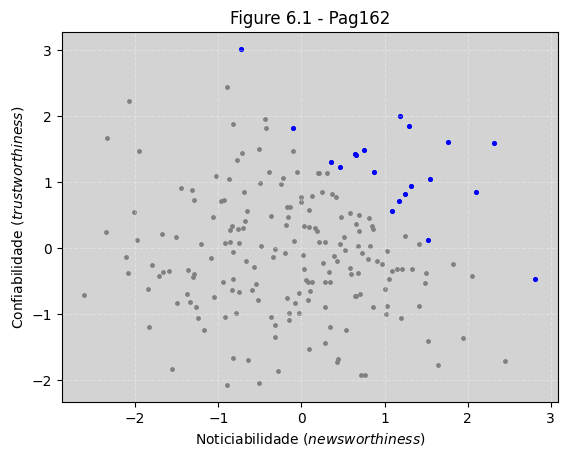

In [4]:
plt.scatter(tw, nw, s=6, color='gray')
plt.scatter(tw[selected], nw[selected], s=7, color='blue')

plt.title('Figure 6.1 - Pag162')
plt.xlabel('Noticiabilidade ($newsworthiness$)')
plt.ylabel('Confiabilidade ($trustworthiness$)')

plt.grid(ls='--', color='white', alpha=0.3)

### RCode 6.2 - pag163


In [5]:
N = 100

np.random.seed(909)  # Teste com outras sementes

height = np.random.normal(10, 2,  N)

leg_proportion = np.random.uniform(0.4, 0.5, N)

leg_left  = np.random.left = leg_proportion * height + np.random.normal(0, 0.02, N)
leg_right = np.random.left = leg_proportion * height + np.random.normal(0, 0.02, N)


df = pd.DataFrame({'height': height, 
                   'leg_left': leg_left, 
                   'leg_right': leg_right})
df.head()

,height,leg_left,leg_right
0,8.463728,4.094675,4.078446
1,9.854070,4.776475,4.687749
2,8.668694,4.192607,4.256472
3,7.523768,3.088674,3.088206
4,9.381352,4.093217,4.048181


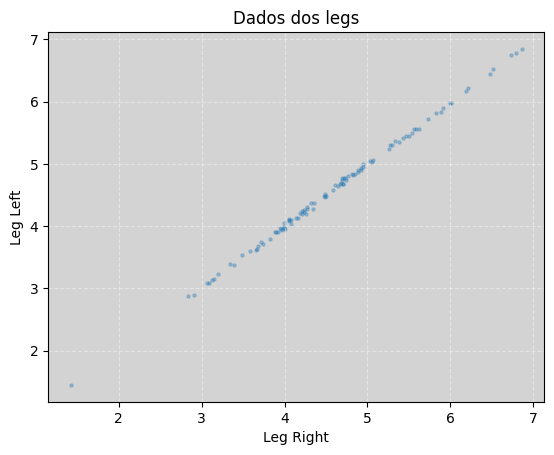

In [6]:
plt.scatter(leg_right, leg_left, s=5, alpha=0.3)

plt.title('Dados dos legs')
plt.xlabel('Leg Right')
plt.ylabel('Leg Left')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

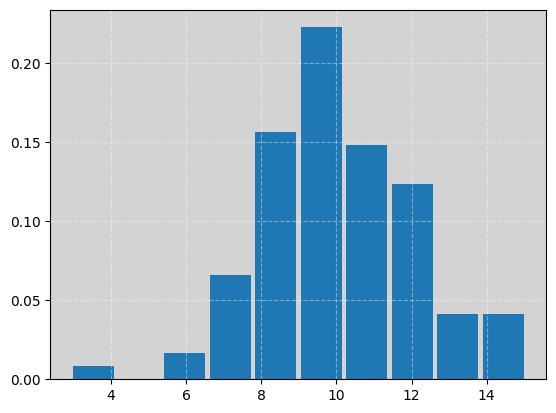

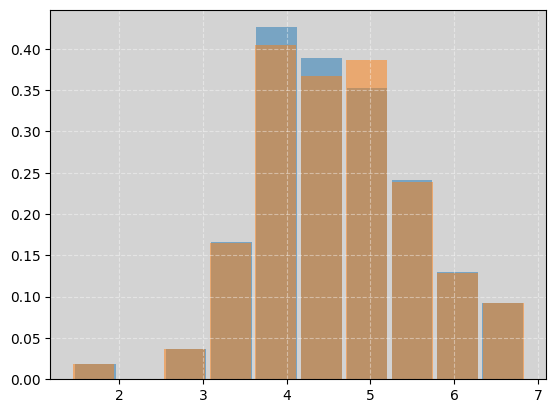

In [7]:
plt.hist(df.height, rwidth=0.9, density=True)
plt.grid(ls='--', color='white', alpha=0.4)
plt.show()

plt.hist(df.leg_left, rwidth=0.9, density=True, alpha=0.5)
plt.hist(df.leg_right, rwidth=0.9, density=True, alpha=0.5)

plt.grid(ls='--', color='white', alpha=0.4)
plt.show()

In [8]:
model = """
    data {
        int<lower=0> N;
        vector[N] height;
        vector[N] leg_left;
        vector[N] leg_right;
    }
    
    parameters {
        real alpha;
        real beta_left;
        real beta_right;
        real<lower=0> sigma; 
    }
    
    model {
        alpha ~ normal(10, 100);
        beta_left ~ normal(2, 10);
        beta_right ~ normal(2, 10);
        sigma ~ exponential(1);
        
        height ~ normal(alpha + beta_left * leg_left + beta_right * leg_right, sigma);
    }
"""

data = {
    'N': N,
    'height': height,
    'leg_left': leg_left,
    'leg_right': leg_right
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

alpha = samples['alpha'].flatten()
beta_left = samples['beta_left'].flatten()
beta_right = samples['beta_right'].flatten()
sigma = samples['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ck8txll7/model_gsymk2uq.stan', line 17, column 27: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  55% (4400/8000)
Sampling:  72% (5800/8000)

### RCode 6.4 - pag164

In [9]:
Vide.summary(samples)

,mean,std,7.0%,93.0%
alpha,0.94,0.33,0.34,1.54
beta_left,-1.54,2.12,-5.20,2.42
beta_right,3.54,2.10,-0.36,7.16
sigma,0.66,0.05,0.58,0.74


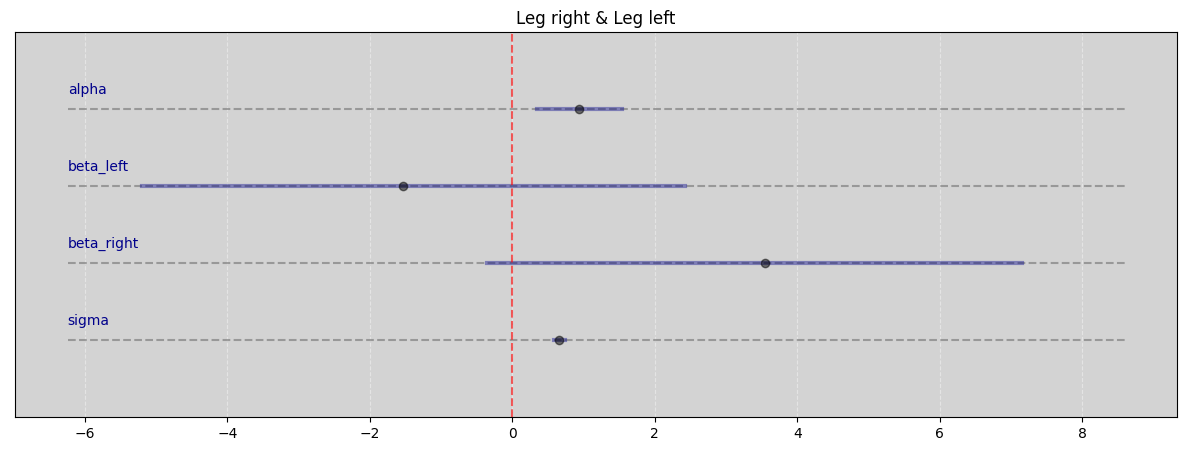

In [10]:
Vide.plot_forest(samples, title='Leg right & Leg left')

### RCode 6.5 - pag164

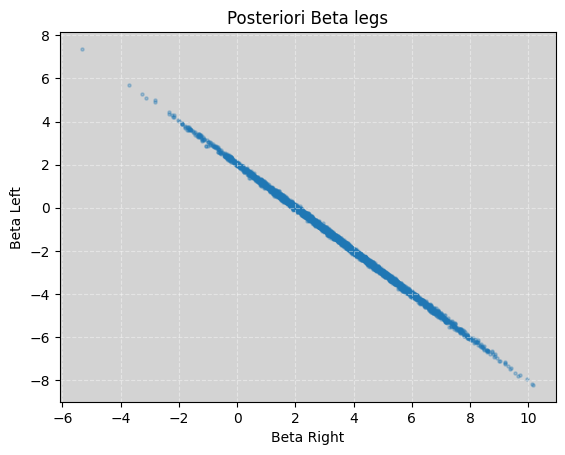

In [11]:
plt.scatter(beta_right, beta_left, s=5, alpha=0.3)

plt.title('Posteriori Beta legs')
plt.xlabel('Beta Right')
plt.ylabel('Beta Left')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

### RCode 6.6 - pag 165

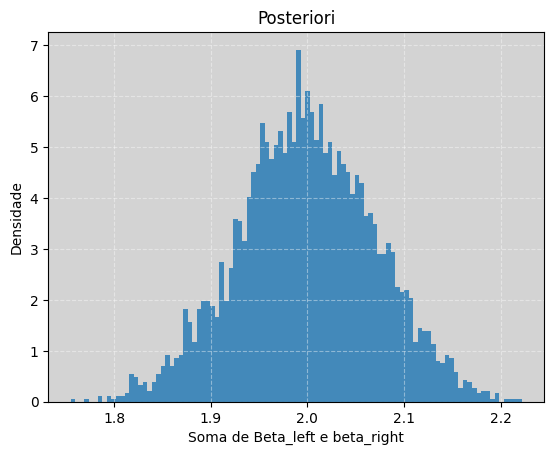

In [12]:
plt.hist((beta_left + beta_right), density=True, alpha=0.8, bins=100)

plt.title('Posteriori')
plt.xlabel('Soma de Beta_left e beta_right')
plt.ylabel('Densidade')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

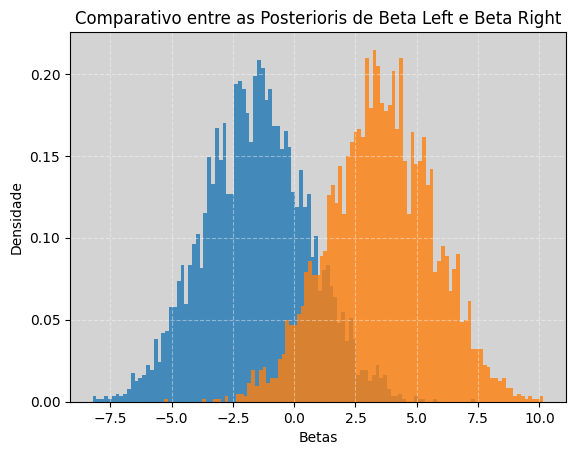

In [13]:
# Comparação com os beta indivíduais

plt.hist(beta_left, density=True, alpha=0.8, bins=100)  # Beta left

plt.hist(beta_right, density=True, alpha=0.8, bins=100)  # Beta Right

plt.title('Comparativo entre as Posterioris de Beta Left e Beta Right')
plt.xlabel('Betas')
plt.ylabel('Densidade')

plt.grid(ls='--', color='white', alpha=0.4)

plt.show()

### RCode 6.7 - Pag 166

In [14]:
model = """
    data {
        int N;
        vector[N] leg_left;
        vector[N] height;
    }
    
    parameters {
        real alpha;
        real beta_left;
        real sigma;
    }
    
    model {
        alpha ~ normal(10, 100);
        beta_left ~ normal(2, 10);
        sigma ~ exponential(1);
        
        height ~ normal(alpha + beta_left * leg_left, sigma);
    }
"""

data = {
    'N': len(height),
    'leg_left': leg_left,
    'height': height,
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

alpha = samples['alpha'].flatten()
beta_left = samples['beta_left'].flatten()
sigma = samples['sigma'].flatten()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_gahyqwl3/model_he7o66lc.stan', line 19, column 54: A normal distribution is given parameter sigma as a scale parameter (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gahyqwl3/model_he7o66lc.stan', line 17, column 8: Parameter sigma is given a exponential distribution, which has strictly positive support, but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_gahyqwl3/model_he7o66lc.stan', line 15, column 27: Argument 100 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: expo

In [15]:
# RCode 6.7 - Continuação
Vide.summary(samples)

,mean,std,7.0%,93.0%
alpha,0.83,0.33,0.27,1.44
beta_left,2.02,0.07,1.89,2.14
sigma,0.67,0.05,0.58,0.75


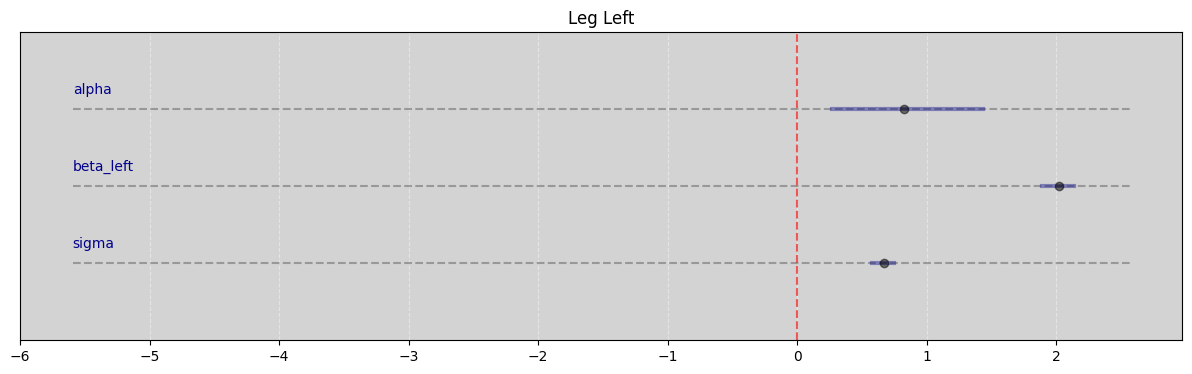

In [16]:
Vide.plot_forest(samples, title='Leg Left')

### R Code 6.8

In [17]:
df = pd.read_csv('data/milk.csv', sep=';')

df_std = df[['kcal.per.g', 'perc.fat', 'perc.lactose']].copy()

df_std['kcal.per.g'] = (df_std['kcal.per.g'] - df_std['kcal.per.g'].mean()) / df_std['kcal.per.g'].std()
df_std['perc.fat'] = (df_std['perc.fat'] - df_std['perc.fat'].mean()) / df_std['perc.fat'].std()
df_std['perc.lactose'] = (df_std['perc.lactose'] - df_std['perc.lactose'].mean()) / df_std['perc.lactose'].std()

df_std.head()

,kcal.per.g,perc.fat,perc.lactose
0,-0.940041,-1.217243,1.307262
1,-0.816126,-1.030355,1.011285
2,-1.125913,-1.391531,1.382679
3,-1.001998,-1.335535,1.586874
4,-0.258511,-0.469693,0.257115


In [18]:
# Não tem nenhum 'missing values'

df_std.isna().sum()

kcal.per.g      0
perc.fat        0
perc.lactose    0
dtype: int64

### R Code 6.9 - Pag 167

In [19]:
# kcal.per.g  regredido em perc.fat

model_kf = """
    data {
        int N;
        vector[N] outcome;
        vector[N] predictor;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    model {
        alpha ~ normal(0, 0.2);
        beta ~ normal(0, 0.5);
        sigma ~ exponential(1);
        
        outcome ~ normal(alpha + beta * predictor, sigma);
    }
"""

data_kf = {
    'N': len(df_std['kcal.per.g']),
    'outcome': list(df_std['kcal.per.g'].values),
    'predictor': list(df_std['perc.fat'].values),
}

posteriori_kf = stan.build(model_kf, data=data_kf)
samples_kf = posteriori_kf.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_p4p2qcr5/model_jcowtlon.stan', line 19, column 8 to column 58)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then yo

In [20]:
# kcal.per.g  regredido em  perc.lactose

model_kl = """
    data {
        int N;
        vector[N] outcome;
        vector[N] predictor;
    }
    
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    
    model {
        alpha ~ normal(0, 0.2);
        beta ~ normal(0, 0.5);
        sigma ~ exponential(1);
        
        outcome ~ normal(alpha + beta * predictor, sigma);
    }
"""

data_kl = {
    'N': len(df_std['kcal.per.g']),
    'outcome': df_std['kcal.per.g'].values,
    'predictor': df_std['perc.lactose'].values,
}

posteriori_kl = stan.build(model_kl, data=data_kl)
samples_kl = posteriori_kl.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_p4p2qcr5/model_jcowtlon.stan', line 19, column 8 to column 58)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your m

In [21]:
Vide.summary(samples_kf)

,mean,std,7.0%,93.0%
alpha,0.00,0.09,-0.15,0.15
beta,0.86,0.09,0.70,1.03
sigma,0.49,0.07,0.37,0.62


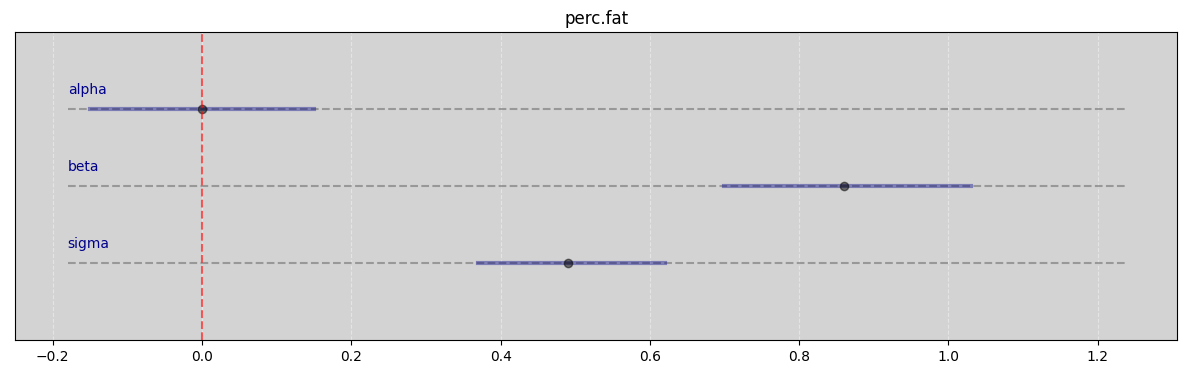

In [22]:
Vide.plot_forest(samples_kf, title='perc.fat')

In [23]:
Vide.summary(samples_kl)

,mean,std,7.0%,93.0%
alpha,0.00,0.07,-0.13,0.13
beta,-0.90,0.08,-1.04,-0.76
sigma,0.41,0.06,0.31,0.52


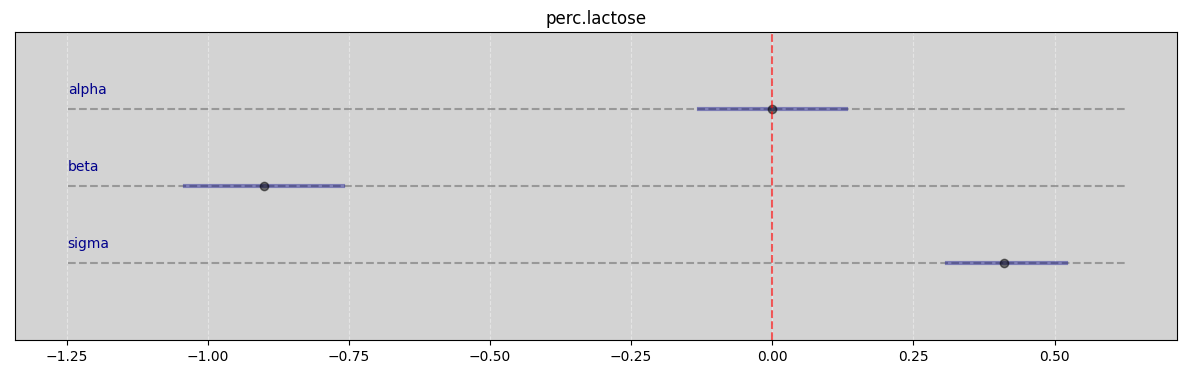

In [24]:
Vide.plot_forest(samples_kl, title='perc.lactose')

### R Code 6.10  -  pag 167

In [25]:
model = """
    data {
        int N;
        vector[N] F;  // Fat
        vector[N] L;  // Lactose
        vector[N] K;  // kcal/g
    }
    
    parameters {
        real alpha;
        real bF;
        real bL;
        real sigma;
    }
    
    model {
        alpha ~ normal(0, 0.2);
        bF ~ normal(0, 0.5);
        bL ~ normal(0, 0.5);
        sigma ~ exponential(1);
        
        K ~ normal(alpha + bF*F + bL*L, sigma);
    }
"""

data = {
    'N': len(df_std['kcal.per.g']),
    'F': df_std['perc.fat'].values,
    'L': df_std['perc.lactose'].values,
    'K': df_std['kcal.per.g'].values,
}

posteriori_FL = stan.build(model, data=data)
samples_FL = posteriori_FL.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ysw33zp7/model_3ukrxt27.stan', line 22, column 40: A normal distribution is given parameter sigma as a scale parameter (argument 2), but sigma was not constrained to be strictly positive.
Warning in '/tmp/httpstan_ysw33zp7/model_3ukrxt27.stan', line 20, column 8: Parameter sigma is given a exponential distribution, which has strictly positive support, but sigma was not constrained to be strictly positive.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: exponential_lpdf: Random variable is -1.96512, but must be nonnegative! (in '/tmp/httpstan_u9mmnqhy/model_3ukrxt27.stan', line 20, column 8 to column 31)
  Rejecting initial value:
    Error evaluating the log probabi

  Exception: exponential_lpdf: Random variable is -0.0396525, but must be nonnegative! (in '/tmp/httpstan_u9mmnqhy/model_3ukrxt27.stan', line 20, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: exponential_lpdf: Random variable is -0.679603, but must be nonnegative! (in '/tmp/httpstan_u9mmnqhy/model_3ukrxt27.stan', line 20, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is ab

In [26]:
Vide.summary(samples_FL)

,mean,std,7.0%,93.0%
alpha,0.00,0.07,-0.13,0.13
bF,0.25,0.20,-0.09,0.63
bL,-0.67,0.20,-1.04,-0.32
sigma,0.41,0.06,0.31,0.52


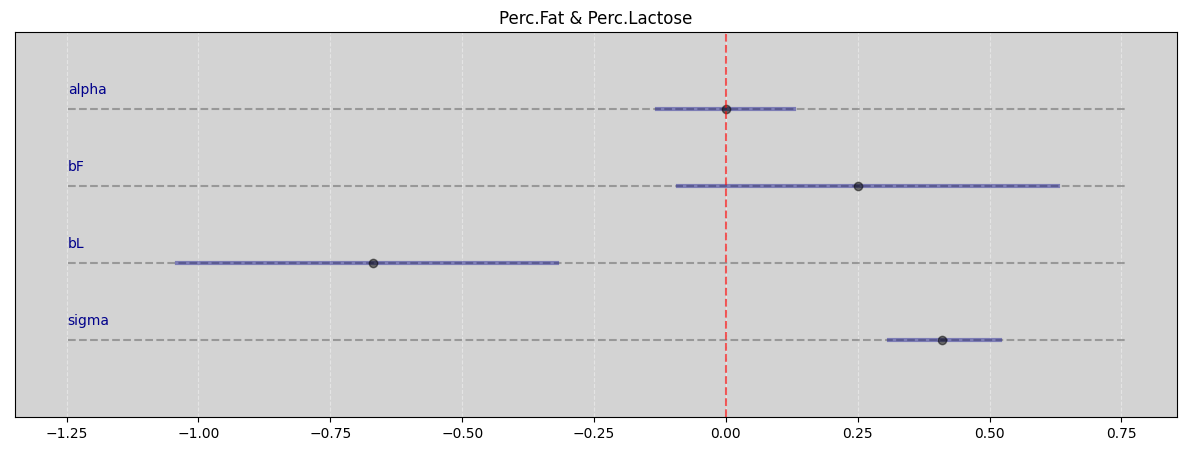

In [27]:
Vide.plot_forest(samples_FL, title='Perc.Fat & Perc.Lactose')

### R Code 6.11 - Pag 168 - Figure 6.3

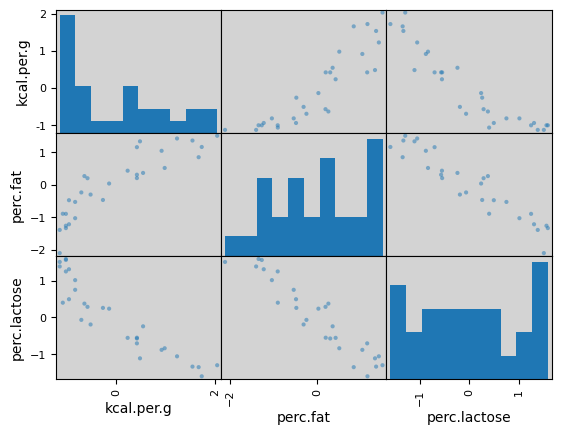

In [28]:
pd.plotting.scatter_matrix(df_std, diagonal='hist', grid=True)
plt.show()

### R Code 6.12 - Overthinking - Rever

In [29]:
model = """
    data {
        int N;
        vector[N] kcal_per_g;
        vector[N] perc_fat;
        vector[N] new_predictor_X;
    }
    
    parameters {
        real alpha;
        real bF;
        real bX;
        real<lower=0> sigma;
    }
    
    model {
        kcal_per_g ~ normal(alpha + bF * perc_fat + bX * new_predictor_X, sigma);
    }
"""

In [30]:
def generate_predictor_x(r=0.9):
    N = len(df['perc.fat'].values)
    
    mean = r * df['perc.fat'].values
    sd = np.sqrt((1 - r**2) * np.var(df['perc.fat'].values))
    
    return np.random.normal(mean, sd, N)  # New Predictor X

In [31]:
def generate_data_dict(r=0.9):
    data = {
        'N': len(df['kcal.per.g']),
        'kcal_per_g': df['kcal.per.g'].values,
        'perc_fat': df['perc.fat'].values,
        'new_predictor_X': generate_predictor_x(r=r),
    }
    return data

In [32]:
def adjust_model(r=0.9):
    
    parameter_mean_samples  = []
    
    for _ in range(1):  # In book running 100x
        # Runnning the model
        posteriori = stan.build(model, data=generate_data_dict(r=r))
        samples = posteriori.sample(num_chains=4, num_samples=1000)
        
        # Get parameter slope mean
        parameter_mean_samples.append(samples['bF'].flatten().mean())
            
    return parameter_mean_samples

In [33]:
stddev = []
r_sequence = np.arange(0, 0.99, 0.1)  # In book using 0.01

for r in r_sequence:
    parameter = adjust_model(r=r)
    stddev.append(np.mean(parameter))

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000

  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition w

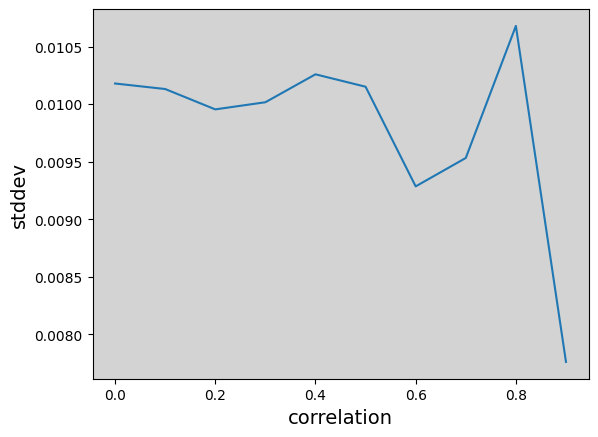

In [34]:
plt.plot(r_sequence, stddev)
plt.xlabel("correlation", fontsize=14)
plt.ylabel("stddev", fontsize=14)
plt.show()

### R Code 6.13

In [35]:
# np.random.seed(71)

# Quantidade de plantas
N = 100

# Simulação inicial das alturas
h0 = np.random.normal(10, 2, N)

# Atribuindo tratamentos e simulando fungos e tratamentos
treatment = np.repeat([0,1], repeats=int(N/2))
fungus = np.random.binomial(n=1, p=(0.5 - treatment*0.4), size=N)
h1 = h0 + np.random.normal(5 - 3*fungus, 1, N)

# Dataframe
d = pd.DataFrame.from_dict({'h0': h0, 
                            'h1': h1, 
                            'treatment': treatment, 
                            'fungus': fungus})
d.describe().T

,count,mean,std,min,25%,50%,75%,max
h0,100.0,9.981135,1.984243,5.186527,8.838553,9.832053,11.320357,14.816656
h1,100.0,14.484326,2.660512,5.184107,12.687494,14.816641,16.142159,20.593327
treatment,100.0,0.500000,0.502519,0.000000,0.000000,0.500000,1.000000,1.000000
fungus,100.0,0.240000,0.429235,0.000000,0.000000,0.000000,0.000000,1.000000


### R Code 6.14

In [36]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))
pd.DataFrame(sim_p, columns=['sim_p']).describe().T

,count,mean,std,min,25%,50%,75%,max
sim_p,10000.0,1.035889,0.264378,0.387121,0.846685,1.001086,1.187977,2.667759


### R Code 6.15

Modelo:

$$ h_{1,i} \sim Normal(\mu_i, \sigma) $$

$$ \mu_i = h_{0, i} \times p $$

Prioris: 

$$ p \sim LogNormal(0, 0.25) $$

$$ sigma \sim Exponential(1) $$

In [37]:
model = """
    data {
        int N; 
        vector[N] h1;
        vector[N] h0;
    }
    
    parameters {
        real<lower=0> p;
        real<lower=0> sigma;
    }
    
    model {
        p ~ lognormal(0, 0.25);  // Priori para p
        sigma ~ exponential(1); 
    
        h1 ~ normal(h0 * p, sigma);
    }
"""


data = {
    'N': N,
    'h1': h1,
    'h0': h0,
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/tmp/httpstan_0e1w2m_k/model_rdgn632j.stan', line 17, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often t

In [38]:
Vide.summary(samples)

,mean,std,7.0%,93.0%
p,1.44,0.02,1.41,1.47
sigma,1.68,0.12,1.48,1.90


### RCode 6.16

Modelo *post-treatment bias*:

$$ h_{1, i} \sim Normal(\mu_i, sigma) $$

$$ \mu_i = h_{0, i} \times p $$

$$ p = \alpha + \beta_T T_i + \beta_F F_i $$

prioris:

$$ \alpha \sim LogNormal(0, 0.25) $$

$$ \beta_T \sim Normal(0, 0.5) $$

$$ \beta_F \sim Normal(0, 0.5) $$

$$ \sigma \sim Exponential(1) $$

In [39]:
model = """
    data {
        int N;
        vector[N] h0;
        vector[N] h1;
        row_vector[N] T;  // Treatment
        row_vector[N] F;  // Fungus
    }

    parameters {
        real alpha;
        real bT;
        real bF;
        real<lower=0> sigma;
    }
    
    transformed parameters {
        
    }
    
    model {
        alpha ~ lognormal(0, 0.25);
        bT ~ normal(0, 0.5);
        bF ~ normal(0, 0.5);
        sigma ~ exponential(1);
    
        h1 ~ normal((alpha + bF*F + bT*T)*h0, sigma);
    }
"""

data = {
    'N': N,
    'h0': h0,
    'h1': h1,
    'T': treatment,
    'F': fungus,
}

posteriori = stan.build(model, data=data)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:110,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/generalized_inverse.hpp: In function ‘Eigen::Matrix<typename stan::value_type<T>::type, EigMat::ColsAtCompileTime, EigMat::RowsAtCompileTime> stan

Building: 6.9s
Building: 7.1s
Building: 7.2s
Building: 7.3s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:321,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/tail.hpp: In function ‘std::vector<T1> stan::math::tail(const std::vector<T1>&, size_t)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/sit

Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:32,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp: In lambda function:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/cholesky_decompose.hpp:83:11: warning: typedef ‘using Block_ = class Eigen::Block<Eigen::Matrix<double, -1, -1>, -1, -1, false>’ local

Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:74,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp: In function ‘auto stan::math::generalized_inverse(const VarMat&)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/generalized_inverse.hpp:64:9: warning: typedef ‘using value_t = stan::value_type_t<T>’

Building: 9.6s
Building: 9.7s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:121,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp: In function ‘auto stan::math::lub_constrain(const T&, const L&, const U&)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/lub_constrain.hpp:485:9: warning: typedef ‘using plain_x_array = stan::plain_type_

Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/bernoulli_logit_glm_log.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/

Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/multi_normal_cholesky_log.hpp:6,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:196,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/ma

Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob/ordered_logistic_log.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/prob.hpp:248,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:13,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/pr

Building: 12.4s
Building: 12.5s
Building: 12.6s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/indexing.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:2:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:329:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  329 |   using pair_type = std::pair<int, arena_vec>;
      |         ^

Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s


/home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp: In instantiation of ‘void model_uonjavwm_namespace::model_uonjavwm::transform_inits_impl(const stan::io::var_context&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_std_vector_t<T>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:485:68:   required from here
/home/rodolpho/.cache/httpstan/4.5.0/models/uonjavwm/model_uonjavwm.cpp:329:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  329 |       int pos__;
      |           ^~~~~


Building: 13.3s
Building: 13.4s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/err.hpp:4,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:8,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Project

Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.6s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.4s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.1s
Building: 24.2s
Building: 24.3s
Building: 24.4s
Building

Building: 30.6s, done.
Messages from stanc:
Warning in '/tmp/httpstan_jxa8ypo1/model_uonjavwm.stan', line 22, column 8: Parameter alpha is given a lognormal distribution, which has strictly positive support, but alpha was not constrained to be strictly positive.
Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:   9% (701/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  44% (3500/8000)
Sampling:  58% (4600/8000)


  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1255.03, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -312.716, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be eithe

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.000825476, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.00244887, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types l

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -15747.3, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -3936.67, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like cov

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.00119683, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -3.96818, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -1.9618e+10, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be ei

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -209.025, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -51.0683, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonj

  Exception: lognormal_lpdf: Random variable is -0.00221809, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Random variable is -0.0173606, but must be nonnegative! (in '/tmp/httpstan_9812n4y1/model_uonjavwm.stan', line 22, column 8 to column 35)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


In [40]:
Vide.summary(samples)

,mean,std,7.0%,93.0%
alpha,0.69,0.13,0.46,0.91
bT,-1.12,0.30,-1.65,-0.62
bF,-0.44,0.48,-1.27,0.44
sigma,2.68,0.19,2.35,3.03


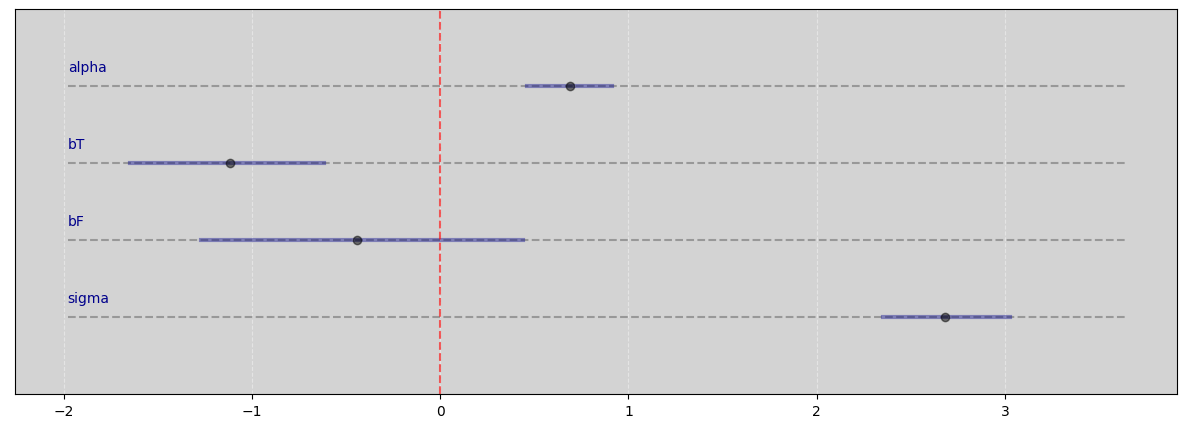

In [41]:
Vide.plot_forest(samples)